In [2]:
import random
import os
import glob
import time
import shutil
import itertools
import cv2


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import class_weight

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import *
from tensorflow.keras.layers import Flatten, Dense, Input, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.regularizers import l2

from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import class_weight

In [3]:
train = pd.read_csv('/kaggle/input/model-datatest-skincancer/train_data.csv')
val = pd.read_csv('/kaggle/input/model-datatest-skincancer/val_data.csv')
test = pd.read_csv('/kaggle/input/model-datatest-skincancer/test_data_remove_unk.csv')

In [4]:
class CFG:
    EPOCHS = 10
    BATCH_SIZE = 32
    SEED = 42
    TF_SEED = 768
    WIDTH = 224
    HEIGHT = 224
    CHANNELS = 3
    IMAGE_SIZE = (224, 224, 3)

In [19]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train['diagnosis']),
    y=train['diagnosis']
)
class_weights_dict = dict(enumerate(class_weights))

In [5]:
def hair_remove(image):
    # convert image to grayScale
    grayScale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # kernel for morphologyEx
    kernel = cv2.getStructuringElement(1, (17, 17))
    
    # apply MORPH_BLACKHAT to grayScale image
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
    
    # apply thresholding to blackhat
    _, threshold = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
    
    # inpaint with original image and threshold image
    final_image = cv2.inpaint(image, threshold, 1, cv2.INPAINT_TELEA)
    
    return final_image

In [10]:
def load_image(image_path):
    # Read and decode an image file to a uint8 tensor
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image, channels=3)
    
    # Resize image
    image = tf.image.resize(image, [CFG.HEIGHT, CFG.WIDTH],
                            method=tf.image.ResizeMethod.LANCZOS3)
    
    image_uint8 = tf.image.convert_image_dtype(image, dtype=tf.uint8)
    
    image_uint8 = tf.numpy_function(hair_remove, [image_uint8], tf.uint8)
    # Convert image dtype to float32 and NORMALIZE!!!
    image = tf.cast(image, tf.float32)/255.
    
    # Return image
    return image

In [7]:
augmentation_layer = Sequential([
    layers.RandomFlip(mode='horizontal_and_vertical', seed=CFG.TF_SEED),
    layers.RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1), seed=CFG.TF_SEED),
], name='augmentation_layer')

In [8]:
def create_pipeline(df, load_function, augment=False, batch_size=32, shuffle=False, cache=None, prefetch=False):
    image_paths = df.path_jpg
    image_labels = df.diagnosis
    AUTOTUNE = tf.data.AUTOTUNE
    
    ds = tf.data.Dataset.from_tensor_slices((image_paths, image_labels))
    
    if augment:
        ds = ds.map(lambda x, y: (augmentation_layer(load_function(x)), y))
    else:
        ds = ds.map(lambda x, y: (load_function(x), y))
    
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
        
    ds = ds.batch(batch_size)
    
    if cache is not None:
        ds = ds.cache(cache)
    
    if prefetch:
        ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    # Return the dataset
    return ds

In [11]:
train_ds = create_pipeline(train, load_image, augment=True, 
                           batch_size=CFG.BATCH_SIZE, 
                           shuffle=True, prefetch=True)

val_ds = create_pipeline(val, load_image, 
                         batch_size=CFG.BATCH_SIZE, 
                         shuffle=False, prefetch=False)


In [12]:
def build_resnet50_model():
    # Load the ResNet50 base model with pre-trained ImageNet weights
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=CFG.IMAGE_SIZE)

    # Make all layers trainable for fine-tuning
    for layer in base_model.layers:
        layer.trainable = True

    # Adding custom layers on top of the base model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, kernel_regularizer=l2(), activation='relu')(x)  # Added kernel_regularizer as l2 instance
    x = Dropout(0.5)(x)
    x = Dense(8, activation='softmax')(x)

    # Create the model
    model = Model(inputs=base_model.input, outputs=x)

    return model

In [13]:
resnet50_model = build_resnet50_model()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
def train_model(model, num_epochs, callbacks_list, tf_train_data, 
                tf_valid_data=None, shuffling=False, class_weight=None):

    
    model_history = {}
    
    if not tf_valid_data:
        validation_data = None
        validation_steps = None
    else:
        validation_data = tf_valid_data
        validation_steps = int(len(tf_valid_data))
        
    model_history = model.fit(tf_train_data,
                              epochs=num_epochs,
                              validation_data=validation_data,
                              validation_steps=validation_steps,
                              callbacks=callbacks_list,
                              shuffle=shuffling,
                             class_weight=class_weight)
        
    return model_history

In [16]:
optimizer = Adam(0.0001)
resnet50_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [17]:
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, mode='max', min_lr=0.00001, verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=2, verbose=1)
model_chkpt = ModelCheckpoint('best_model_dn121.keras', save_best_only=True, monitor='val_accuracy', verbose=1)

callback_list = [model_chkpt, lr_reduce, early_stop]

In [20]:
print(f'Training {resnet50_model.name}.')
print(f'Train on {len(train)} samples, validate on {len(val)} samples.')
print('----------------------------------')

resnet50_model_history = train_model(
    resnet50_model, CFG.EPOCHS, callback_list, 
    train_ds, val_ds,
    shuffling=False,class_weight=class_weights_dict 
)

Training functional_1.
Train on 20264 samples, validate on 5067 samples.
----------------------------------
Epoch 1/10
634/634 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4005 - loss: 5.9932
Epoch 1: val_accuracy improved from -inf to 0.50641, saving model to best_model_dn121.keras
634/634 ━━━━━━━━━━━━━━━━━━━━ 898s 1s/step - accuracy: 0.4006 - loss: 5.9923 - val_accuracy: 0.5064 - val_loss: 5.6096 - learning_rate: 1.0000e-04
Epoch 2/10
634/634 ━━━━━━━━━━━━━━━━━━━━ 422s 639ms/step - accuracy: 0.5441 - loss: 4.1969 - learning_rate: 1.0000e-04
Epoch 3/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accura

634/634 ━━━━━━━━━━━━━━━━━━━━ 0s 640ms/step - accuracy: 0.5840 - loss: 3.1046
Epoch 3: val_accuracy improved from 0.50641 to 0.68976, saving model to best_model_dn121.keras
634/634 ━━━━━━━━━━━━━━━━━━━━ 484s 736ms/step - accuracy: 0.5840 - loss: 3.1043 - val_accuracy: 0.6898 - val_loss: 2.4089 - learning_rate: 1.0000e-04
Epoch 4/10
634/634 ━━━━━━━━━━━━━━━━━━━━ 426s 644ms/step - accuracy: 0.6190 - loss: 2.3383 - learning_rate: 1.0000e-04
Epoch 5/10
634/634 ━━━━━━━━━━━━━━━━━━━━ 0s 624ms/step - accuracy: 0.6482 - loss: 1.7812
Epoch 5: val_accuracy did not improve from 0.68976
634/634 ━━━━━━━━━━━━━━━━━━━━ 470s 715ms/step - accuracy: 0.6482 - loss: 1.7811 - val_accuracy: 0.6688 - val_loss: 1.6162 - learning_rate: 1.0000e-04
Epoch 6/10
634/634 ━━━━━━━━━━━━━━━━━━━━ 418s 633ms/step - accuracy: 0.6698 - loss: 1.4007 - learning_rate: 1.0000e-04
Epoch 7/10
634/634 ━━━━━━━━━━━━━━━━━━━━ 0s 630ms/step - accuracy: 0.6863 - loss: 1.1473
Epoch 7: val_accuracy did not improve from 0.68976

Epoch 7: Reduce

<Axes: >

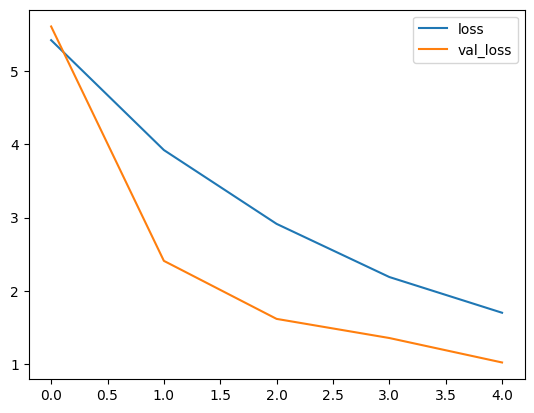

In [23]:
history_dict = resnet50_model.history.history
min_length = min(len(history_dict["loss"]), len(history_dict["val_loss"]))
metrics = pd.DataFrame({
    "loss": history_dict["loss"][:min_length],
    "val_loss": history_dict["val_loss"][:min_length]
})
metrics.plot()

# Test_ds

In [26]:
def create_pipeline_test(df, load_image, batch_size=32, prefetch=True):
    image_paths = df["path_jpg"].values
    dataset = tf.data.Dataset.from_tensor_slices(image_paths).map(load_image)

    dataset = dataset.batch(batch_size)

    if prefetch:
        dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

In [27]:
test_ds = create_pipeline_test(test, load_image, batch_size=CFG.BATCH_SIZE, prefetch=True)

# Eval

In [28]:
best_model = tf.keras.models.load_model("/kaggle/working/best_model_dn121.keras")

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [29]:
test_preds = best_model.predict(test_ds)

194/194 ━━━━━━━━━━━━━━━━━━━━ 164s 831ms/step


In [30]:
test_labels_pred = np.argmax(test_preds, axis=1)

In [31]:
test['prediction'] = test_labels_pred

In [32]:
test_data = test[['image', 'prediction']]

In [33]:
test_data

,image,prediction
0,ISIC_0034321,1
1,ISIC_0034322,5
2,ISIC_0034323,1
3,ISIC_0034324,5
4,ISIC_0034325,5
...,...,...
6186,ISIC_0073226,1
6187,ISIC_0073234,2
6188,ISIC_0073236,1
6189,ISIC_0073243,3


In [34]:
class_mapping = {0: 'AK', 1: 'BCC', 2: 'BKL', 3: 'DF', 4: 'MEL', 5: 'NV', 6: 'SCC', 7: 'VASC'}
test_data['diagnosis'] = test_data['prediction'].map(class_mapping)
test_data.head()

<ipython-input-34-dead8306c724>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['diagnosis'] = test_data['prediction'].map(class_mapping)


,image,prediction,diagnosis
0,ISIC_0034321,1,BCC
1,ISIC_0034322,5,NV
2,ISIC_0034323,1,BCC
3,ISIC_0034324,5,NV
4,ISIC_0034325,5,NV


In [35]:
test_gt = pd.read_csv('/kaggle/input/model-datatest-skincancer/test_gt_remove_unk.csv')
test_gt.head()

,image,diagnosis
0,ISIC_0034321,NV
1,ISIC_0034322,NV
2,ISIC_0034323,BCC
3,ISIC_0034324,NV
4,ISIC_0034325,NV


In [36]:
accuracy = (test_data['diagnosis'] == test_gt['diagnosis']).mean()
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.6471
